In [1]:
#lines for google colab
#!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
#!pip install forgi
#!tar -xf data.tar.xz
import os
import datetime
import numpy as np
import torch as th
import torch_geometric.transforms as T
from torch_geometric.loader import DenseDataLoader, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import sys
sys.path.append("../classifier/")
from model.data import CGDataset, VectorCGDataset, NeighbourCGDataset
from model.model import DiffCG, MinCutCG, DMoNCG, DeepCG
from run.train import training
from run.test import test


print("Pytorch Version", th.__version__)
print("Cuda is available:", th.cuda.is_available())

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print("Using device:", device)

vectorize = True
k = 0

dataset_dict = {c.__name__: c for c in {CGDataset, VectorCGDataset, NeighbourCGDataset}}

if vectorize:
    dataset_v = "VectorCGDataset"
elif k > 0:
    dataset_v = "NeighbourCGDataset"
else:
    dataset_v = "CGDataset"

#Training Set
training_dir = "../data/train_set"
rmsd_list = "../data/truncated_train_rmsd.txt" #"data/train_rmsd_list.txt" #
training_dataset = dataset_dict[dataset_v](training_dir, rmsd_list, k=k)# T.NormalizeScale()) #, transform=transform_fn

#Validation Set
val_dir = "../data/val_set"
val_rmsd = "../data/val_rmsd_list.txt"
val_dataset = dataset_dict[dataset_v](val_dir, val_rmsd, k=k)#, transform=T.NormalizeScale()) #, transform=transform_fn

#Test Data
test_dir = "../data/test_set"
test_rmsd = "../data/test_rmsd_list.txt"
test_dataset = dataset_dict[dataset_v](test_dir, test_rmsd, k=k)#, transform=T.NormalizeScale()) #, transform=transform_fn

#5S rRNA and tRNA Test Data (previous training data)
st_test_dir = "../data/old_training_set"
st_test_rmsd = "../data/old_train_rmsd_list.txt"
st_test_dataset = dataset_dict[dataset_v](st_test_dir, st_test_rmsd, k=k)#, transform=T.NormalizeScale()) #, transform=transform_fn

#Rotated Test Sets
test_dir_rot = "../data/test_set_rot"
test_rmsd = "../data/test_rmsd_list.txt"
rot_test_dataset = dataset_dict[dataset_v](test_dir_rot, test_rmsd, k=k)#, transform=T.NormalizeScale()) #, transform=transform_fn

fst_test_rot = "../data/5st_test_rot"
fst_rot_dataset = dataset_dict[dataset_v](fst_test_rot, st_test_rmsd, k=k)#, transform=T.NormalizeScale()) #, transform=transform_fn

Pytorch Version 1.11.0
Cuda is available: True
Using device: cuda


TODO:
*  Should Vector and Neighbour datasets inherit from CGDataset, to avoid code duplication?
*  **Check why fewer graphs are loaded into the training dataset than are in the rmsd list** --> change from InMemoryDataset to Dataset **DONE**  --> duplicates in train rmsd list leads to discrepancy
*  Add further that start of s1 is in yz-plane with s0 **Semi-DONE** (theres still a range of angles)
*  are there additional tertiary interactions detected to add?
*  softplus or relu for last classification step? if any non-linearity that ensures that no negative results are returned?
*  try skip-cat/-sum in layer architecture?
    * use the module `JumpingKnowledge` in PyG

Normalization:
*  BatchNorm: no improvement seen, maybe with larger datasets?
*  PairNorm: Training took longer, results were nonsense
*  DiffGroupNorm: figure out how to configure it (in channels not the same as for the layers)
*  GraphNorm: Strange results, try again. (maybe with GINConv layers, as is shown in the paper?), doesnt seem to work in this case (at least with normal data)
*  LayerNorm: Training took longer, results were worse than without norm
*  InstanceNorm: doesnt work for 3D input? --> try pytorch instancenorm1(?)d instead of pygs

--> try data normalization/standardization (beforehand)

In [2]:
model = DeepCG(training_dataset.num_node_features, 56, 14)

01.07.2022 16:29:44 Creating Training Directory at 2022-07-01_16-29_DeepCG/
01.07.2022 16:29:44 Using CUDNN Benchmark
01.07.2022 16:29:47 Loading Datasets
01.07.2022 16:29:47 Start Training


Epoch 0: Training loss 16.9260; Validation loss 21.8302, MAE: 22.3004; lr: 0.00000
	Add. Loss: Training 0.0000, Validation 0.0000
Epoch 5: Training loss 16.4504; Validation loss 20.6627, MAE: 21.1565; lr: 0.00020
	Add. Loss: Training 0.0000, Validation 0.0000
Epoch 10: Training loss 13.9535; Validation loss 18.1785, MAE: 18.6766; lr: 0.00040
	Add. Loss: Training 0.0000, Validation 0.0000
Epoch 15: Training loss 7.9414; Validation loss 16.7585, MAE: 17.2558; lr: 0.00060
	Add. Loss: Training 0.0000, Validation 0.0000
Epoch 20: Training loss 4.6229; Validation loss 16.0288, MAE: 16.5208; lr: 0.00080
	Add. Loss: Training 0.0000, Validation 0.0000
Epoch 25: Training loss 3.2229; Validation loss 15.8574, MAE: 16.3444; lr: 0.00100
	Add. Loss: Training 0.0000, Validation 0.0000
Epoch 30: Training loss 2.2459; Validation loss 15.9734, MAE: 16.4631; lr: 0.00080
	Add. Loss: Training 0.0000, Validation 0.0000
Epoch 35: Training loss 2.0143; Validation loss 15.8490, MAE: 16.3428; lr: 0.00060
	Add. 

01.07.2022 16:55:22 Training took 0.43 hours
01.07.2022 16:55:22 Minimum Training Loss 0.0431 in epoch 997
01.07.2022 16:55:22 Minimum Validation Loss (after 50 epochs) 14.3597 in epoch 958
01.07.2022 16:55:22 Minimum MAE (after 50 epochs) 14.8520 in epoch 958
01.07.2022 16:55:22 Seed used for training was: 16305556388141354430


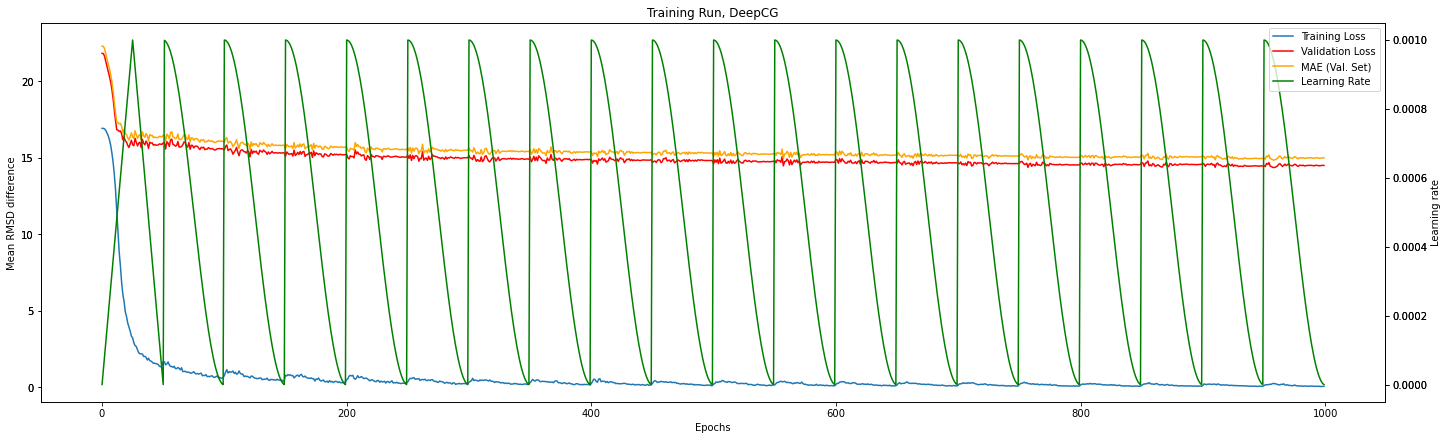

In [3]:
#Training
parent_dir = "../run_data/"

#with th.autograd.detect_anomaly():
training(
    model=model,
    train_dataset=training_dataset,
    val_dataset=val_dataset,
    model_dir=parent_dir,
    device=device,
    b_size=64,
    lr=1e-3,
    epochs=1_000,
    sched_T0=50,
    vectorize=vectorize,
    k=k,
    #num_workers=0,
    #resume="run_data/2022-05-17_12-18_MinCut_CG_Classifier/model_data/epoch_4516.pth",
    burn_in=50)

In [4]:
#get training run data

run_dir = "../run_data/2022-07-01_16-29_DeepCG"
burn_in = 50

file_lines = []
with open(run_dir + "/loss_data.txt", "r") as fh:
    for line in fh.readlines():
        file_lines.append(line.rstrip("]\n").lstrip("[").split(","))

epoch_losses = [float(a) for a in file_lines[0]]
val_losses = [float(b) for b in file_lines[1]]
learning_rates = [float(c) for c in file_lines[2]]
mae_losses = [float(d) for d in file_lines[3]]
epoch_add_losses = [float(d) for d in file_lines[4]]

print(f"Minimum Training Loss {min(epoch_losses):.4f} in epoch {epoch_losses.index(min(epoch_losses))}")
print(f"Minimum Validation Loss (after {burn_in} epochs) {min(val_losses[burn_in:]):.4f} in epoch {val_losses.index(min(val_losses[burn_in:]))}")
print(f"Minimum MAE (after {burn_in} epochs) {min(mae_losses[burn_in:]):.4f} in epoch {mae_losses.index(min(mae_losses[burn_in:]))}")


Minimum Training Loss 0.0431 in epoch 997
Minimum Validation Loss (after 50 epochs) 14.3597 in epoch 958
Minimum MAE (after 50 epochs) 14.8520 in epoch 958


Validation Loss at 958 is 14.3597
5 before select
14.5731, 14.6864, 14.4564, 14.4332, 14.3745
5 after select
14.3817, 14.4263, 14.4658, 14.5816, 14.6188
MAE at 958 is 14.8520


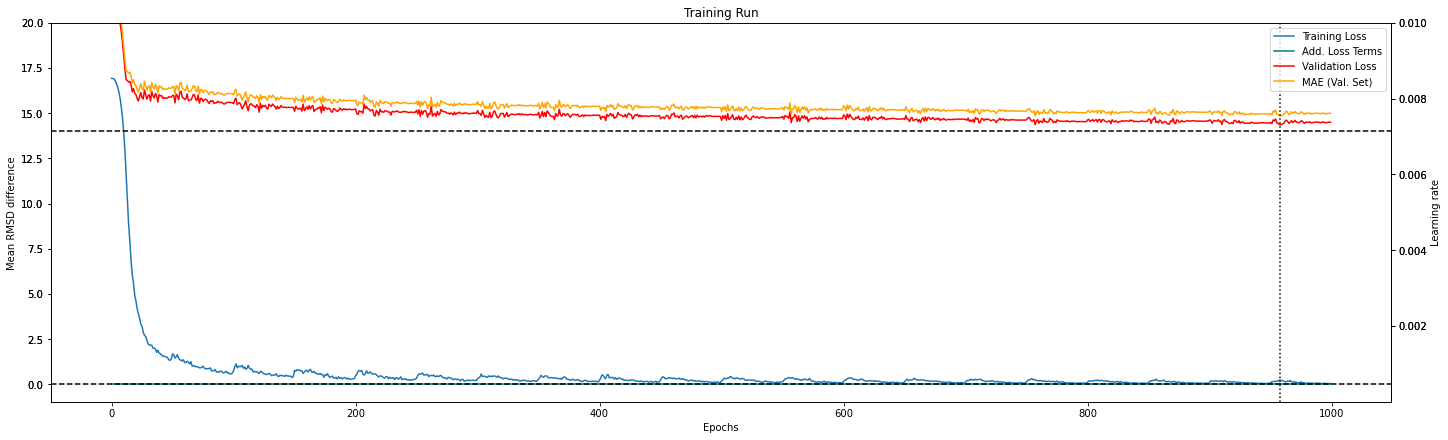

In [5]:
#plot the training run
select = 958

print(f"Validation Loss at {select} is {val_losses[select]:.4f}")
print("5 before select")
print((", ").join([f"{x:.4f}" for x in val_losses[select-5:select]]))
print("5 after select")
print((", ").join([f"{y:.4f}" for y in val_losses[select+1:select+6]]))
print(f"MAE at {select} is {mae_losses[select]:.4f}")

fig, ax1 = plt.subplots(layout="constrained", figsize=(20, 6))
ax1.secondary_yaxis("left")
ax1.plot(epoch_losses, label="Training Loss")
ax1.plot(epoch_add_losses, "teal", label="Add. Loss Terms")
ax1.plot(val_losses, "r", label="Validation Loss")
ax1.plot(mae_losses, "orange", label="MAE (Val. Set)")

ax2 = ax1.twinx()
ax2.secondary_yaxis("right")
#ax2.plot(learning_rates, "g", label="Learning Rate")
plt.title("Training Run")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Mean RMSD difference")
ax2.set_ylabel("Learning rate")

ax1.set_ylim([(min(epoch_losses)-1), 20]) #max(val_losses)+2)
plt.axvline(x = select, c = "black", ls = ':')
ax1.axhline(y=0, c = "black", ls = "--")
ax1.axhline(y=14, c = "black", ls = "--")

ax2.set_ylim([(min(learning_rates)/10), max(learning_rates)*10])

han1, lab1 = ax1.get_legend_handles_labels()
han2, lab2 = ax2.get_legend_handles_labels()
plt.legend(han1 + han2, lab1 + lab2, loc="upper right")
plt.draw()

Using state dict from epoch 958
Test Set
Minimum Loss: Label = 22.3040, Prediction = 22.3298, Loss = 0.0003
Maximum Loss: Label = 0.0000, Prediction = 29.1383, Loss = 28.6383
Mean Test loss: 	 12.8998
Std. Dev. of Test loss:  7.6671
Min loss: 		 0.0003
First Quantile: 	 7.0224
Median: 		 10.9436
Third Quantile: 	 18.9533
Max Loss: 		 28.6383
LinregressResult(slope=-1.0399779097996098, intercept=36.00058288917664, rvalue=-0.4120482597189271, pvalue=8.879055867190001e-13, stderr=0.13867727314975925, intercept_stderr=2.6504761669130006)


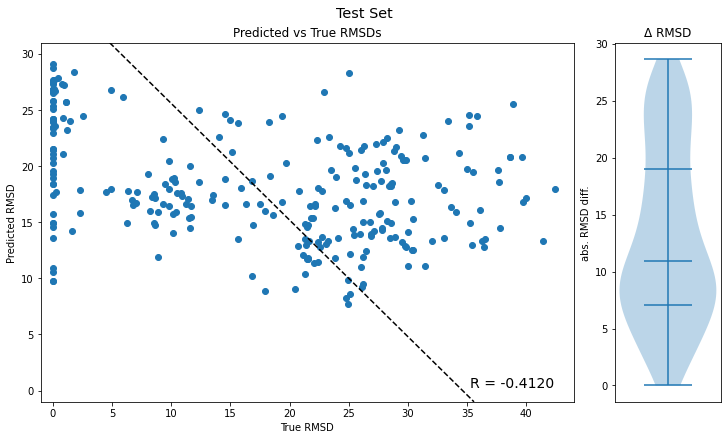

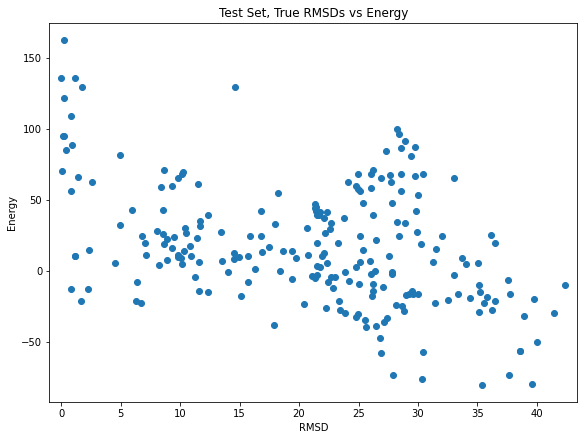

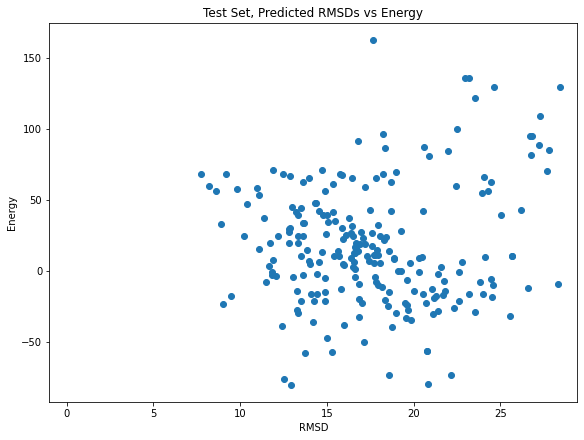

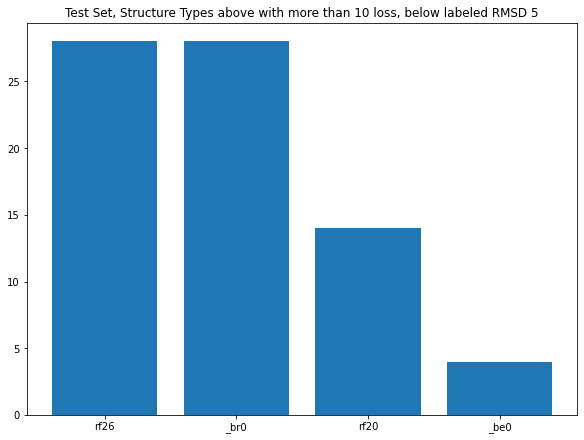

5S and tRNA Test Set
Minimum Loss: Label = 1.3240, Prediction = 1.3171, Loss = 0.0000
Maximum Loss: Label = 0.0000, Prediction = 21.5428, Loss = 21.0428
Mean Test loss: 	 4.1700
Std. Dev. of Test loss:  4.2321
Min loss: 		 0.0000
First Quantile: 	 1.1237
Median: 		 3.0281
Third Quantile: 	 5.5117
Max Loss: 		 21.0428
LinregressResult(slope=1.0051828831569445, intercept=-1.466557836695097, rvalue=0.724716608430361, pvalue=4.692818957409257e-177, stderr=0.029067849386416673, intercept_stderr=0.5357361992683102)


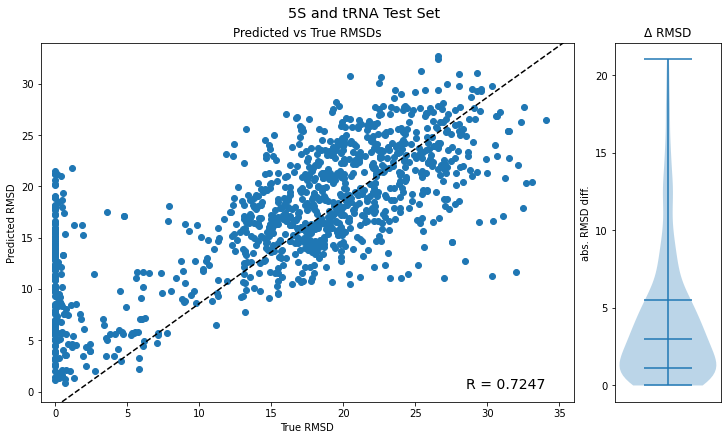

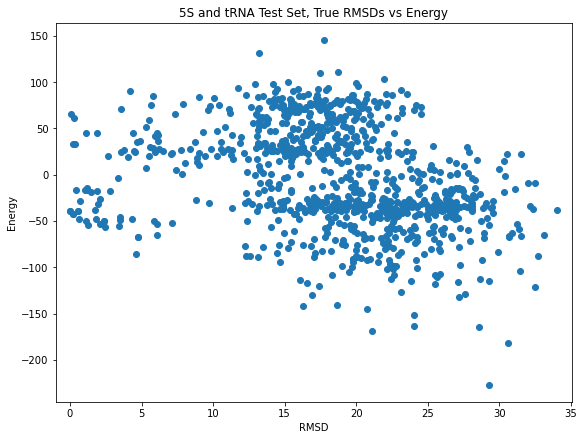

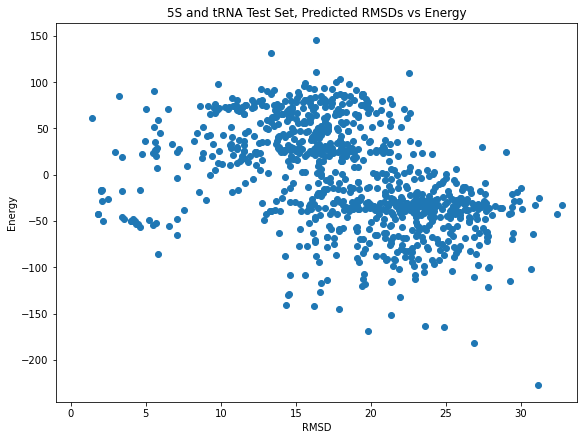

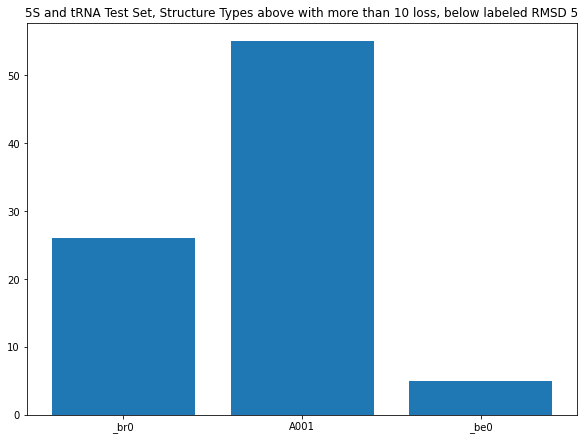

Prediction below 0: Label 0.2620, Pred -0.0716
Prediction below 0: Label 0.2620, Pred -0.0716
Prediction below 0: Label 0.2340, Pred -0.1910
Prediction below 0: Label 0.1620, Pred -0.1830
Training Set
Minimum Loss: Label = 22.0760, Prediction = 22.0743, Loss = 0.0000
Maximum Loss: Label = 18.7240, Prediction = 21.4060, Loss = 2.1820
Mean Test loss: 	 0.2057
Std. Dev. of Test loss:  0.3019
Min loss: 		 0.0000
First Quantile: 	 0.0187
Median: 		 0.0940
Third Quantile: 	 0.2507
Max Loss: 		 2.1820
LinregressResult(slope=0.9923328580756735, intercept=-0.048229567344403534, rvalue=0.9975938269053423, pvalue=0.0, stderr=0.0025048749108192024, intercept_stderr=0.05085903196486943)


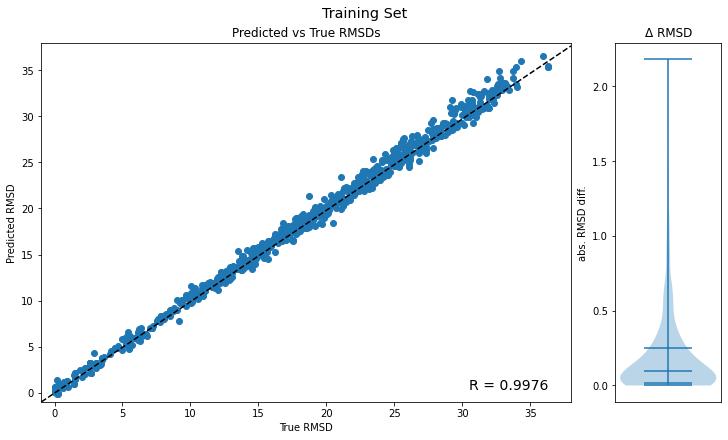

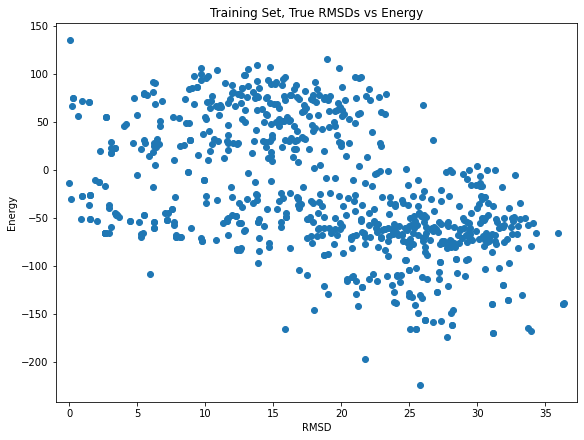

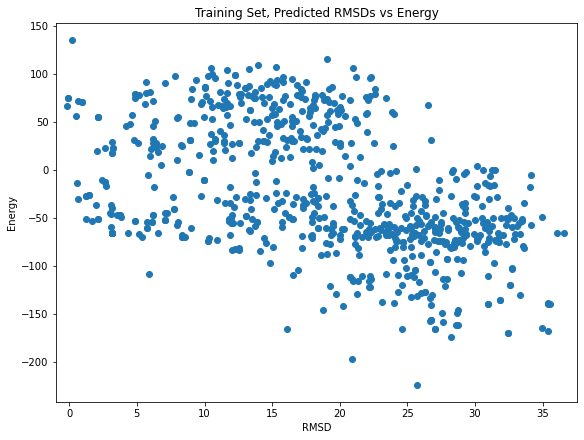

Validation Set
Minimum Loss: Label = 23.0020, Prediction = 22.9502, Loss = 0.0013
Maximum Loss: Label = 61.9850, Prediction = 15.7255, Loss = 45.7595
Mean Test loss: 	 14.1577
Std. Dev. of Test loss:  10.3307
Min loss: 		 0.0013
First Quantile: 	 4.8962
Median: 		 12.7380
Third Quantile: 	 21.5263
Max Loss: 		 45.7595
LinregressResult(slope=-0.21329810879982747, intercept=27.55723240047619, rvalue=-0.082592174597897, pvalue=0.10076152155522185, stderr=0.12966228024565446, intercept_stderr=2.742168956086508)


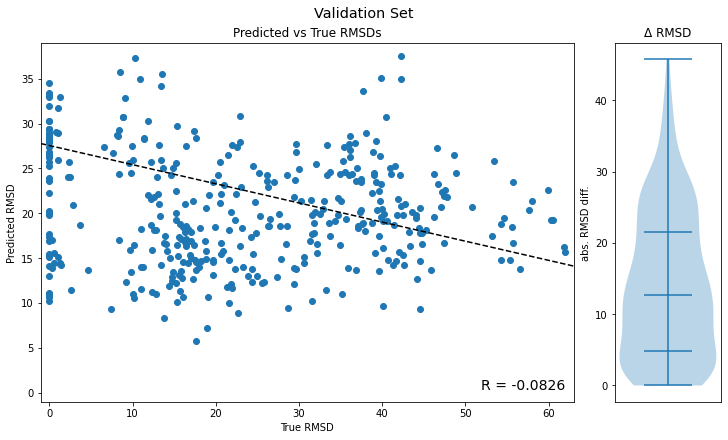

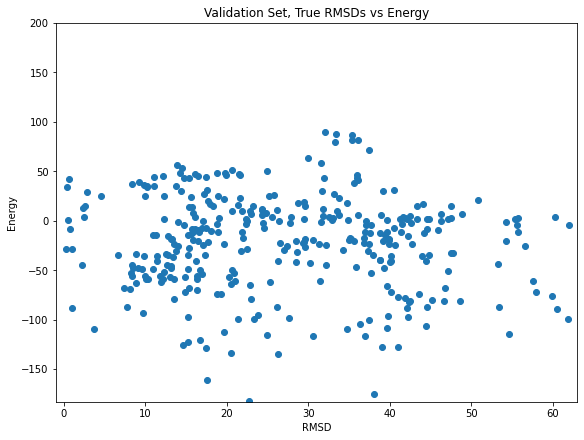

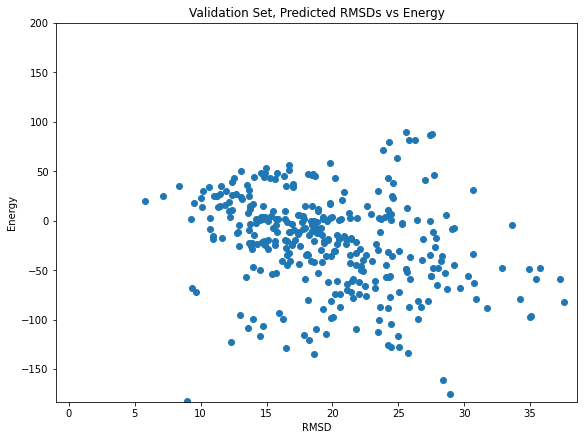

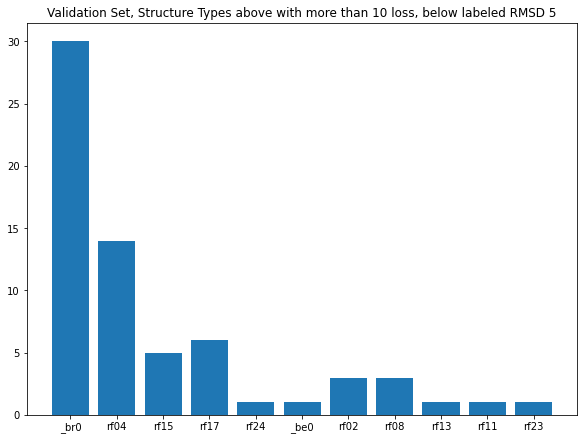

LinregressResult(slope=0.5249490395176709, intercept=11.04935683231904, rvalue=0.29795256115485974, pvalue=6.016624072020923e-32, stderr=0.04358482566509935, intercept_stderr=0.848884645116358)


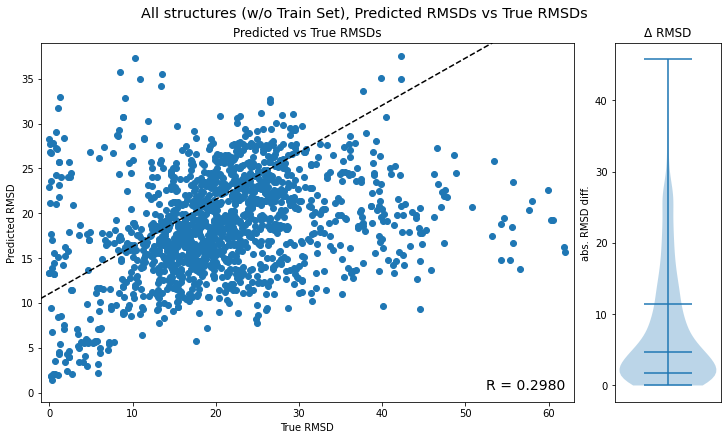

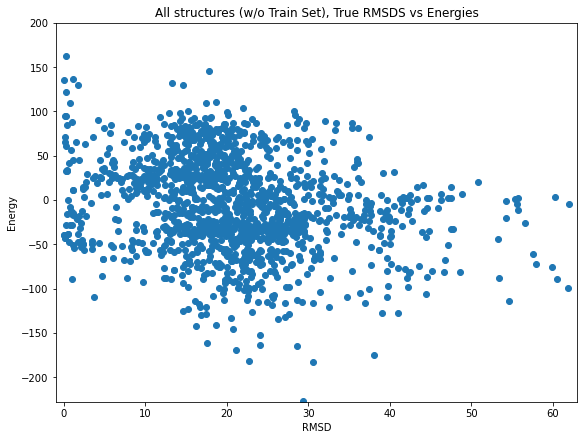

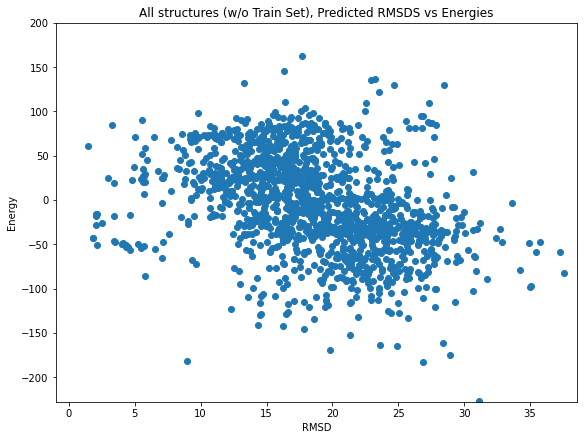

In [6]:
#Test
from run.utility import get_energy_dict, rmsd_scatter, e_rmsd_scatter

# loss cutoff for type histo
cutoff = [10, 5]

train_loader = DataLoader(training_dataset, batch_size=1)
val_loader = DataLoader(val_dataset, batch_size=1)
test_dataloader = DataLoader(test_dataset, batch_size=1)
st_test_dataloader = DataLoader(st_test_dataset, batch_size=1)

model.to(device)
checkpoint = th.load(f"{run_dir}/model_data/epoch_{select}.pth")
print(f"Using state dict from epoch {checkpoint['epoch']}")
model.load_state_dict(checkpoint["model_state_dict"])

energy_l = []
true_rmsd_l = []
pred_rmsd_l = []
test_ls = []
for loader in [test_dataloader, st_test_dataloader, train_loader, val_loader]:
    if loader == test_dataloader:
        title = "Test Set"
        e_dict = get_energy_dict("../data/test_energy.txt")
    elif loader == st_test_dataloader:
        title = "5S and tRNA Test Set"
        e_dict = get_energy_dict("../data/old_train_energy.txt")
    elif loader == train_loader:
        title = "Training Set"
        e_dict = get_energy_dict("../data/train_energy.txt")
    elif loader == val_loader:
        title = "Validation Set"
        e_dict = get_energy_dict("../data/val_energy.txt")
    en, trs, prs, tlosses = test(model, loader, e_dict, title, device, cutoff)
    if loader != train_loader:
        energy_l += en
        true_rmsd_l += trs
        pred_rmsd_l += prs
        test_ls += tlosses

        

rmsd_scatter(pred_rmsd_l, true_rmsd_l, test_ls, "All structures (w/o Train Set), Predicted RMSDs vs True RMSDs")
e_rmsd_scatter(energy_l, true_rmsd_l, "All structures (w/o Train Set), True RMSDS vs Energies")
e_rmsd_scatter(energy_l, pred_rmsd_l, "All structures (w/o Train Set), Predicted RMSDS vs Energies")

LinregressResult(slope=0.9091579813203675, intercept=1.8185265564939073, rvalue=0.9366382501401529, pvalue=2.694587713881415e-127, stderr=0.020504017003080147, intercept_stderr=0.40753690556040806)


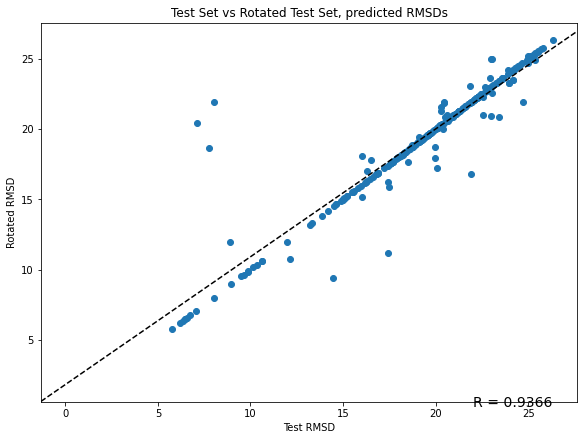

LinregressResult(slope=0.9786476636103387, intercept=0.3422918149869716, rvalue=0.9785232101141297, pvalue=1.2132055836684666e-190, stderr=0.012432089962595764, intercept_stderr=0.168440886827594)


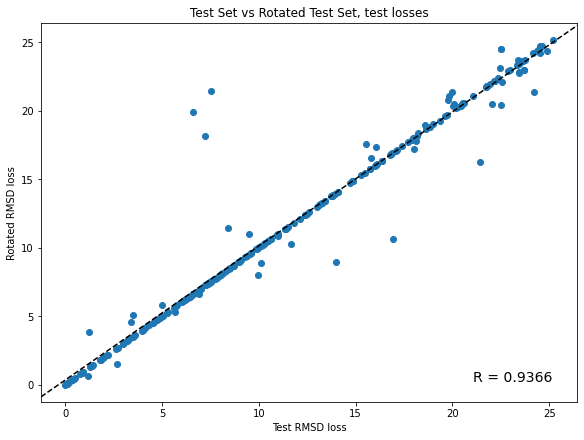

LinregressResult(slope=0.9712626165796127, intercept=0.5077173948013183, rvalue=0.9651781637725774, pvalue=0.0, stderr=0.00800650792132218, intercept_stderr=0.15077171482414378)


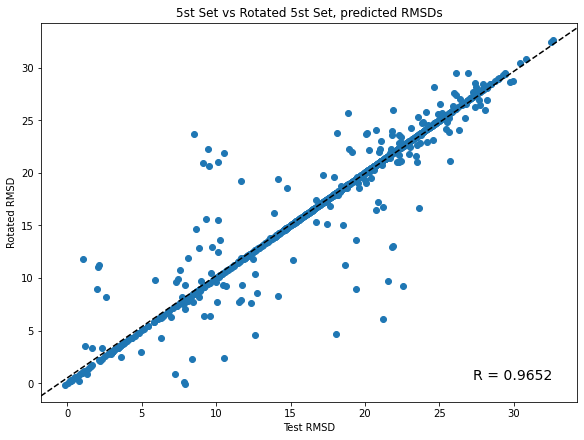

LinregressResult(slope=0.9253551594236874, intercept=0.29146281014302033, rvalue=0.9308669272310164, pvalue=0.0, stderr=0.011046561261775974, intercept_stderr=0.07107113242709055)


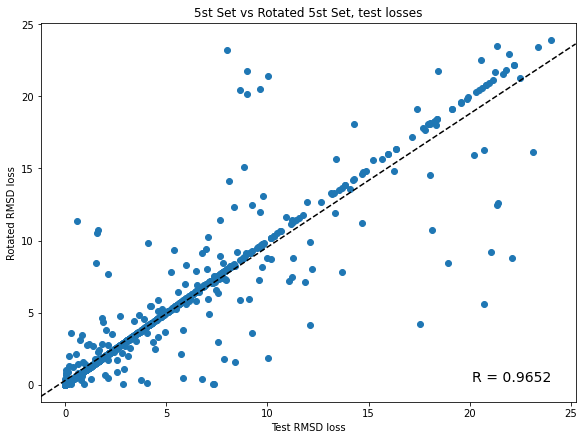

In [20]:
#Test run for rotational invariance
from scipy.stats import linregress
rot_test_dataloader = DataLoader(rot_test_dataset, batch_size=1)
fst_rot_dataloader = DataLoader(fst_rot_dataset, batch_size=1)

def rot_eval(dataloader, rot_dataloader):
    pred_dir = {}
    loss_dir = {}
    for loader in [dataloader, rot_dataloader]:
        with th.no_grad():
            model.eval()
            for test_graph in loader:
                test_graph = test_graph.to(device)
                test_pred, _ = model(test_graph)
                test_loss = F.smooth_l1_loss(test_pred, test_graph.y).item()

                if test_graph.name[0] not in pred_dir.keys():
                    pred_dir[test_graph.name[0]] = [float(test_pred)]
                else:
                    pred_dir[test_graph.name[0]].append(float(test_pred))
                
                if test_graph.name[0] not in loss_dir.keys():
                    loss_dir[test_graph.name[0]] = [float(test_loss)]
                else:
                    loss_dir[test_graph.name[0]].append(float(test_loss))
    return pred_dir, loss_dir

def rot_plot(pred_dir, loss_dir, title):
    test_preds = []
    trot_preds = []
    for a in pred_dir.keys():
        test_preds.append(pred_dir[a][0])
        trot_preds.append(pred_dir[a][1])

    test_ls = []
    trot_ls = []
    for b in loss_dir.keys():
        test_ls.append(loss_dir[b][0])
        trot_ls.append(loss_dir[b][1])

    reg = linregress(test_preds, trot_preds)
    print(reg)

    fig1, axs1 = plt.subplots(layout='constrained', figsize=(8, 6))
    plt.title(title + ", predicted RMSDs")
    axs1.scatter(test_preds, trot_preds)
    axs1.axline(xy1=(0, reg.intercept), slope=reg.slope, linestyle="--", color="k")
    axs1.text(max(test_preds), 0.01, f"R = {reg.rvalue:.4f}", fontsize=14, verticalalignment="bottom", horizontalalignment="right")
    plt.xlabel("Test RMSD")
    plt.ylabel("Rotated RMSD")
    plt.show()

    reg_l = linregress(test_ls, trot_ls)
    print(reg_l)

    fig2, axs2 = plt.subplots(layout='constrained', figsize=(8, 6))
    plt.title(title + ", test losses")
    axs2.scatter(test_ls, trot_ls)
    axs2.axline(xy1=(0, reg_l.intercept), slope=reg_l.slope, linestyle="--", color="k")
    axs2.text(max(test_ls), 0.01, f"R = {reg.rvalue:.4f}", fontsize=14, verticalalignment="bottom", horizontalalignment="right")
    plt.xlabel("Test RMSD loss")
    plt.ylabel("Rotated RMSD loss")
    plt.show()

test_pred_dir, test_loss_dir = rot_eval(test_dataloader, rot_test_dataloader)
rot_plot(test_pred_dir, test_loss_dir, "Test Set vs Rotated Test Set")

fst_pred_dir, fst_loss_dir = rot_eval(st_test_dataloader, fst_rot_dataloader)
rot_plot(fst_pred_dir, fst_loss_dir, "5st Set vs Rotated 5st Set")